In [494]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

### Read In Data

In [495]:
df = pd.read_parquet('s3://moneygans-data/basketball_nba/starting_money/starting_money_agg/starting_money_all.parquet', engine='pyarrow')[['pos_money','neg_money']]
real_df = df
data = df.values.astype(np.float32)
data.shape

(942, 2)

### Plotting and Test Functions

In [506]:
def plot_real_vs_generated(real_df, gen_df):
    """
    Creates a scatter plot comparing real and generated data points.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(real_df['pos_money'], real_df['neg_money'], label='Real Data', color='blue', alpha=0.6)
    plt.scatter(gen_df['pos_money'], gen_df['neg_money'], label='Generated Data', color='orange', alpha=0.6)
    plt.title('Real Data vs. Generated Data')
    plt.xlabel('Positive Money Line')
    plt.ylabel('Negative Money Line')
    plt.legend()
    plt.show()

def plot_feature_distributions(real_df, gen_df):
    """
    Creates histograms comparing the distribution of features between real and generated data.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.histplot(real_df['pos_money'], kde=True, color='blue', label='Real', ax=axes[0])
    sns.histplot(gen_df['pos_money'], kde=True, color='orange', label='Generated', ax=axes[0])
    axes[0].set_title('Distribution of Positive Money Line')
    axes[0].legend()

    sns.histplot(real_df['neg_money'], kde=True, color='blue', label='Real', ax=axes[1])
    sns.histplot(gen_df['neg_money'], kde=True, color='orange', label='Generated', ax=axes[1])
    axes[1].set_title('Distribution of Negative Money Line')
    axes[1].legend()
    plt.show()

def perform_ks_test(real_df, gen_df, show_results=True):
    """
    Perform Kolmogorov-Smirnov tests for both marginal distributions and joint distribution.
    Compares real data with generated data.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
    """
    
    # Perform KS test for positive moneyline
    ks_stat_pos, p_value_pos = ks_2samp(real_df['pos_money'], gen_df['pos_money'])
    
    # Perform KS test for negative moneyline  
    ks_stat_neg, p_value_neg = ks_2samp(real_df['neg_money'], gen_df['neg_money'])
    
    # Perform 2D KS test for joint distribution
    real_joint = np.column_stack((real_df['pos_money'], real_df['neg_money']))
    gen_joint = np.column_stack((gen_df['pos_money'], gen_df['neg_money']))
    ks_stat_2d, p_value_2d = ks_2samp(real_joint.ravel(), gen_joint.ravel())
    
    if show_results:
        # Print results
        print("Kolmogorov-Smirnov Test Results:")
        print("\nPositive Moneyline:")
        print(f"KS statistic: {ks_stat_pos:.4f}")
        print(f"p-value: {p_value_pos:.4f}")
        print(f"Null hypothesis (distributions are the same): {'Not rejected' if p_value_pos > 0.05 else 'Rejected'}")
        
        print("\nNegative Moneyline:")
        print(f"KS statistic: {ks_stat_neg:.4f}") 
        print(f"p-value: {p_value_neg:.4f}")
        print(f"Null hypothesis (distributions are the same): {'Not rejected' if p_value_neg > 0.05 else 'Rejected'}")
        
        print("\nJoint Distribution:")
        print(f"KS statistic: {ks_stat_2d:.4f}")
        print(f"p-value: {p_value_2d:.4f}")
        print(f"Null hypothesis (distributions are the same): {'Not rejected' if p_value_2d > 0.05 else 'Rejected'}")

    return {
        'positive': ks_stat_pos,
        'negative': ks_stat_neg,
        'joint': ks_stat_2d
    }

def calculate_wasserstein_distances(real_df, gen_df, show_results=True):
    """
    Calculate Wasserstein distances between real and generated distributions
    for both positive and negative moneylines.
    
    Args:
        real_df (DataFrame): DataFrame containing real data
        gen_df (DataFrame): DataFrame containing generated data
        
    Returns:
        dict: Dictionary containing Wasserstein distances for both distributions
    """

    
    # Calculate Wasserstein distance for positive moneyline
    wd_pos = wasserstein_distance(real_df['pos_money'], gen_df['pos_money'])
    
    # Calculate Wasserstein distance for negative moneyline
    wd_neg = wasserstein_distance(real_df['neg_money'], gen_df['neg_money'])
    
    if show_results:    
        # Print results
        print("Wasserstein Distance Results:")
        print(f"\nPositive Moneyline: {wd_pos:.4f}")
        print(f"Negative Moneyline: {wd_neg:.4f}")
    
    return {
        'positive': wd_pos,
        'negative': wd_neg
    }


### Generator Architecture

In [497]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)  # Fit and transform the data first
real_data = torch.tensor(scaled_data)
batch_size = 64  # Adjust batch size as needed
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the Generator network with Batch Normalization, Dropout, and more layers
class Generator(nn.Module):
    def __init__(self, noise_dim=10, output_dim=2):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),      # Input layer: maps noise to 256 dimensions
            nn.BatchNorm1d(256),            # Normalize the activations
            nn.ReLU(inplace=True),          # ReLU activation
            nn.Dropout(0.3),                # Dropout for regularization
            nn.Linear(256, 512),            # Hidden layer 1: expands to 512 dimensions
            nn.BatchNorm1d(512),            # Normalize the activations
            nn.ReLU(inplace=True),          # ReLU activation
            nn.Dropout(0.3),                # Dropout for regularization
            nn.Linear(512, 256),            # Hidden layer 2: reduces to 256 dimensions
            nn.BatchNorm1d(256),            # Normalize the activations
            nn.ReLU(inplace=True),          # ReLU activation
            nn.Dropout(0.3),                # Dropout for regularization
            nn.Linear(256, output_dim),     # Output layer: final projection to output dimensions
        )

    def forward(self, z):
        return self.model(z)

# Hyperparameters
noise_dim = 10
n_epochs = 5000  # Increase epochs for better results
lr = 1e-4
n_critic = 5  # Number of critic iterations per generator iteration

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == 'cuda':
    print("GPU:", torch.cuda.get_device_name(0))
G = Generator(noise_dim=noise_dim, output_dim=2).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))


Using device: cpu


### Loads the saved generator model

In [498]:
# Load the saved model
checkpoint = torch.load('wgan_model.pth')
G.load_state_dict(checkpoint['generator_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])


### Generates synthetic data

In [499]:
N = len(real_data)

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(N, noise_dim).to(device)
    generated_samples = G(z).cpu().numpy()

# Inverse transform the data if normalized
generated_samples = scaler.inverse_transform(generated_samples)
real_data_np = scaler.inverse_transform(real_data.numpy())

# Convert to DataFrames for easier plotting
real_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])
gen_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])

### Results

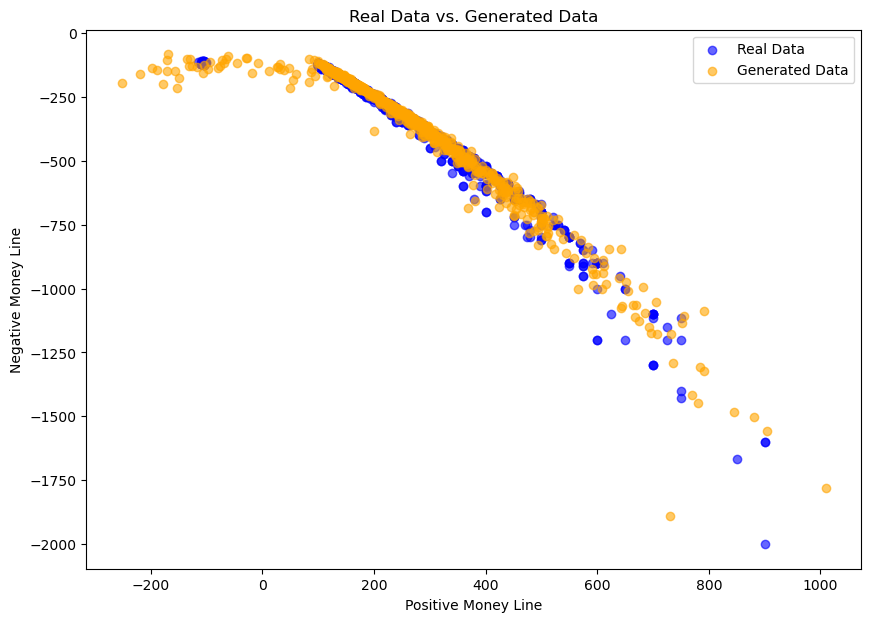

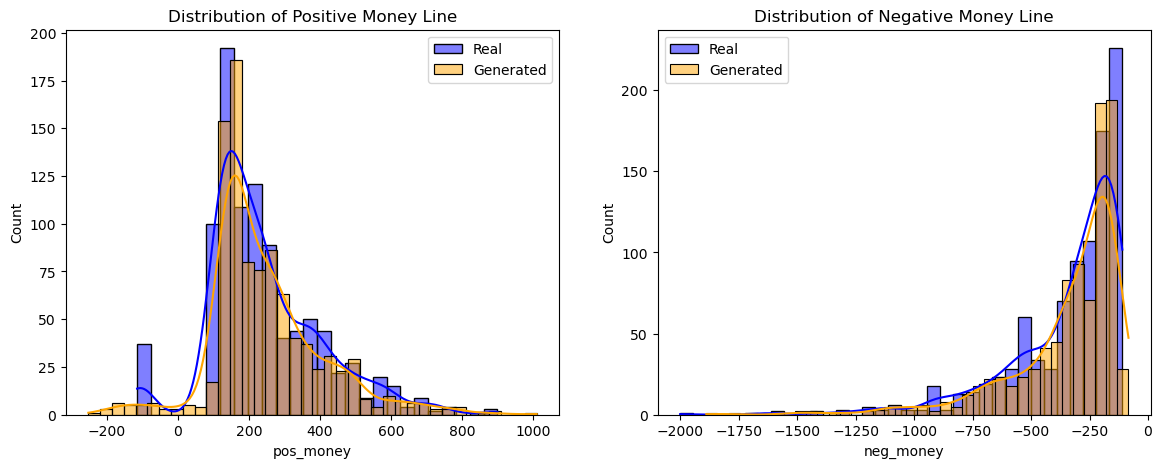

In [500]:
plot_real_vs_generated(real_df, gen_df)
plot_feature_distributions(real_df, gen_df)

In [501]:
perform_ks_test(real_df, gen_df)
print()
calculate_wasserstein_distances(real_df, gen_df)

Kolmogorov-Smirnov Test Results:

Positive Moneyline:
KS statistic: 0.1062
p-value: 0.0000
Null hypothesis (distributions are the same): Rejected

Negative Moneyline:
KS statistic: 0.1115
p-value: 0.0000
Null hypothesis (distributions are the same): Rejected

Joint Distribution:
KS statistic: 0.0610
p-value: 0.0018
Null hypothesis (distributions are the same): Rejected

Wasserstein Distance Results:

Positive Moneyline: 13.1187
Negative Moneyline: 14.9791


{'positive': 13.118671030502158, 'negative': 14.979074069142595}

## Monte Carlo Experiment
1. Sample Z from MVN
2. Pass through network to generate data
3. Calculate and store KS and Wasserstein Statistics
4. Repeat N times
5. Calculate mean and construct 95 % CI

In [524]:
n_gen = len(real_data) # Number of generated samples
N = 10000 # Number of Monte Carlo samples

# Initialize numpy arrays to store statistics
KS_stats_pos = np.zeros(N)
KS_stats_neg = np.zeros(N)
KS_stats_joint = np.zeros(N)
W_stats_pos = np.zeros(N)
W_stats_neg = np.zeros(N)

# Monte Carlo Loop
for i in range(N):
    # Generate synthetic data
    with torch.no_grad():
        z = torch.randn(n_gen, noise_dim).to(device)
        generated_samples = G(z).cpu().numpy()

    # Inverse transform the data if normalized
    generated_samples = scaler.inverse_transform(generated_samples)
    real_data_np = scaler.inverse_transform(real_data.numpy())

    # Convert to DataFrames for easier plotting
    real_df = pd.DataFrame(real_data_np, columns=['pos_money', 'neg_money'])
    gen_df = pd.DataFrame(generated_samples, columns=['pos_money', 'neg_money'])

    # Store statistics directly in numpy arrays
    KS_stats_pos[i] = perform_ks_test(real_df, gen_df, show_results=False)['positive'] # Calculate KS statistic for positive moneyline
    KS_stats_neg[i] = perform_ks_test(real_df, gen_df, show_results=False)['negative'] # Calculate KS statistic for negative moneyline
    KS_stats_joint[i] = perform_ks_test(real_df, gen_df, show_results=False)['joint'] # Calculate KS statistic for joint distribution
    
    W_stats_pos[i] = calculate_wasserstein_distances(real_df, gen_df, show_results=False)['positive'] # Calculate Wasserstein statistic for positive moneyline
    W_stats_neg[i] = calculate_wasserstein_distances(real_df, gen_df, show_results=False)['negative'] # Calculate Wasserstein statistic for negative moneyline


Statistical Results:
--------------------------------------------------

KS Positive:
Mean: 0.096
95% CI: [0.064, 0.127]

KS Negative:
Mean: 0.096
95% CI: [0.062, 0.130]

KS Joint:
Mean: 0.051
95% CI: [0.035, 0.068]

W Positive:
Mean: 12.566
95% CI: [9.466, 16.768]

W Negative:
Mean: 14.362
95% CI: [10.337, 19.824]


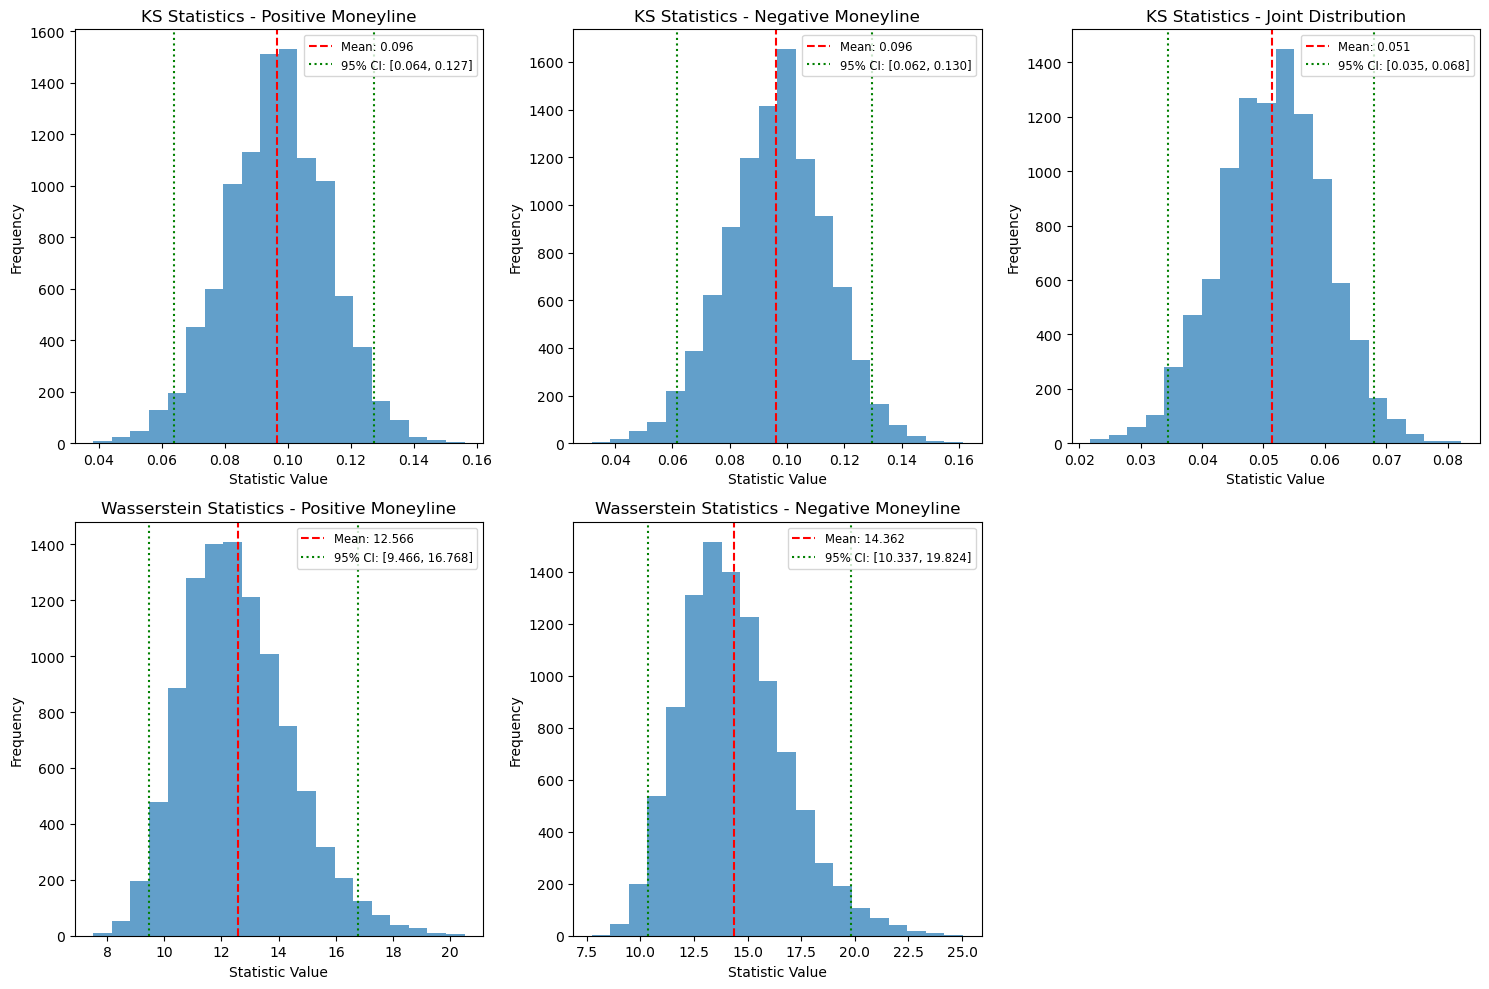

In [526]:
# Calculate 95% confidence intervals
ci_level = 0.95
lower_quantile = (1 - ci_level) / 2
upper_quantile = 1 - lower_quantile

stats = {
    'KS Positive': {'data': KS_stats_pos, 'title': 'KS Statistics - Positive Moneyline'},
    'KS Negative': {'data': KS_stats_neg, 'title': 'KS Statistics - Negative Moneyline'}, 
    'KS Joint': {'data': KS_stats_joint, 'title': 'KS Statistics - Joint Distribution'},
    'W Positive': {'data': W_stats_pos, 'title': 'Wasserstein Statistics - Positive Moneyline'},
    'W Negative': {'data': W_stats_neg, 'title': 'Wasserstein Statistics - Negative Moneyline'}
}

# Print statistics and confidence intervals
print("\nStatistical Results:")
print("-" * 50)
for name, stat in stats.items():
    ci = np.quantile(stat['data'], [lower_quantile, upper_quantile])
    mean = np.mean(stat['data'])
    print(f"\n{name}:")
    print(f"Mean: {mean:.3f}")
    print(f"95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")

# Create a figure with 5 subplots
plt.figure(figsize=(15, 10))

# Plot each statistic with CI
for i, (name, stat) in enumerate(stats.items(), 1):
    plt.subplot(2, 3, i)
    plt.hist(stat['data'], bins=20, alpha=0.7)
    
    # Calculate and plot confidence intervals
    ci = np.quantile(stat['data'], [lower_quantile, upper_quantile])
    mean = np.mean(stat['data'])
    
    # Add vertical lines for mean and CI
    plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.3f}')
    plt.axvline(ci[0], color='g', linestyle=':', label=f'95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]')
    plt.axvline(ci[1], color='g', linestyle=':')
    
    plt.title(stat['title'])
    plt.xlabel('Statistic Value')
    plt.ylabel('Frequency')
    plt.legend(fontsize='small')

plt.tight_layout()
plt.show()
